<a href="https://colab.research.google.com/github/DeepLearningInterpreter/occlusion_experiments/blob/master/colab_notebooks/Visualizing_Detections_With(out)_Occlusion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Introduction

The purpose of this notebook is to detect the pistol(s) on images and visualize these detections by drawing bounding boxes. Optionally, an occlusion box can be placed in the image to see how the models deal with the occlusion. The notebook is structured as follows.

**First** you can choose whether you want to use SSD or Faster R-CNN.

**The next few parts** are important but can be skipped or quickly glanced over. In these parts, the repository is cloned to the cloud server, the necessary imports are taken care of, the model is loaded into memory, and some helpful functions are defined.

**The final part** of the notebook is the most interesting. Here, you can specify the images of interest and optionally draw a bounding box in the image. The detection visualizations will be printed.

##Choose Your Model
Choose the meta architecture that you want to use.


In [0]:
#Set this variable equal to "SSD" or "FRCNN" (for Faster R-CNN)
meta_architecture = "SSD"

In [0]:
if meta_architecture == "SSD":
  MODEL_NAME = "SSD_ext_lrCyc"
  MODEL_TYPE = "SSD"
elif meta_architecture == "FRCNN":
  MODEL_NAME = "FRCNN_ext_lr3"
  MODEL_TYPE = "FRCNN"
else:
  raise ValueError(
      'The meta_architecture variable has to be set to either "SSD" or "FRCNN".'
  )

---------------------------------------------------------------------------
##Cloning the GitHub repository to the cloud server. 



In [3]:
#Downloading and installing git lfs
!curl -s https://packagecloud.io/install/repositories/github/git-lfs/script.deb.sh | sudo bash
!sudo apt-get install git-lfs
!git lfs install

Detected operating system as Ubuntu/bionic.
Checking for curl...
Detected curl...
Checking for gpg...
Detected gpg...
Running apt-get update... done.
Installing apt-transport-https... done.
Installing /etc/apt/sources.list.d/github_git-lfs.list...done.
Importing packagecloud gpg key... done.
Running apt-get update... done.

The repository is setup! You can now install packages.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 72 not upgraded.
Need to get 4,931 kB of archives.
After this operation, 12.3 MB of additional disk space will be used.
Get:1 https://packagecloud.io/github/git-lfs/ubuntu bionic/main amd64 git-lfs amd64 2.6.1 [4,931 kB]
Fetched 4,931 kB in 1s (9,500 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/per

In [4]:
#This takes a few minutes but less than five for sure!

#Cloning repository. The exclude flag indicates that large files from the "training" and "evaluation_outcomes" 
#subdirectories should not be downloaded
!git lfs clone https://github.com/DeepLearningInterpreter/occlusion_experiments.git --exclude="occlusion_experiments/main_content/multitude_of_possible_detectors/training, occlusion_experiments/main_content/multitude_of_possible_detectors/evaluation_outcomes"

          with new flags from 'git clone'

'git clone' has been updated in upstream Git to have comparable
speeds to 'git lfs clone'.
Cloning into 'occlusion_experiments'...
remote: Enumerating objects: 175, done.
remote: Counting objects: 100% (175/175), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 2173 (delta 117), reused 101 (delta 52), pack-reused 1998
Receiving objects: 100% (2173/2173), 185.84 MiB | 28.78 MiB/s, done.
Resolving deltas: 100% (394/394), done.
Checking out files: 100% (2206/2206), done.


In [5]:
import os
os.chdir("/content/occlusion_experiments/TF_object_detection_API_modified")
os.chdir("object_detection")
os.getcwd()

'/content/occlusion_experiments/TF_object_detection_API_modified/object_detection'

---------------------------------------------------------------------------------------------------------------------
##Imports and function definitions

In [0]:
# coding: utf-8

# # Imports
import csv
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tensorflow as tf
import time

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image
import scipy.misc

sys.path.append("..")
from utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')
  



In [0]:
#makes sure there is no printing output
%%capture 

#more imports
from object_detection.utils import label_map_util
from utils import visualization_utils as vis_util

In [0]:
os.chdir('/content/occlusion_experiments/main_content')

In [0]:
# # Model preparation

path_to_model = 'multitude_of_possible_detectors/frozen_models_for_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = path_to_model + MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data/main_data', 'pistol_car_label_map.pbtxt')

#Load a (frozen) Tensorflow model into memory.
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')


#Loading label map
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)


#Helper code
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

end of imports and function definitions.

-------------------------------------------------------------
##Begin occlusion and inference


Specify the name of the image of interest in this cell. The image will be printed so you can decide where to draw the occlusion box.  

In [10]:
#Specify the index of the image of interest. To see which index corresponds 
#to which image, uncomment the second to next codeblock and run it.
image_index = 7

#printing image
with open('data/occlusion_images/nameAndBB.csv') as f:
  reader = csv.reader(f)
  image_info = list(reader)
  
print(image_index)
image_path = "data/occlusion_images/" + image_info[image_index][0]
image = Image.open(image_path)
image_np = load_image_into_numpy_array(image)
plt.imshow(image_np)
plt.show()

7


Decide the location of the occlusion box. If you do not want to occlude anything you can set the *size* variable to zero.

In [0]:
#The next two variables decide where the top left corner of the occlusion box
#will be. Choosing x0 = 0 and y0 = 0 means that the top left corner of the
#occlusion box will be in the top left corner of the image.
x0 = 403 #along the horizontal axis
y0 = 125 #along the vertical axis

#This parameter decides the size of the box in terms of the number of pixels.
#Set size = 0 for no occlusion
size = 80

With the following codeblock you can find out which image corresponds to what index.
Just uncomment and run the code below:

In [0]:
# with open('data/occlusion_images/nameAndBB.csv') as f:
#   reader = csv.reader(f)
#   image_info = list(reader)
  

# for i in range(1,30):
#   print(i)
#   image_path = "data/occlusion_images/" + image_info[i][0]
#   image = Image.open(image_path)
#   image_np = load_image_into_numpy_array(image)
#   plt.imshow(image_np)
#   plt.show()

Run the cell below and the visualization of the detection will be printed.

4.4403910636901855


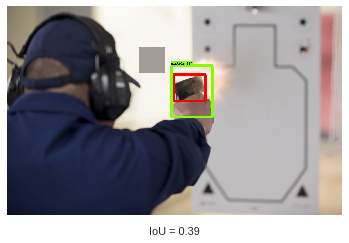

The intersection over union is:  0.3928882872378966
Confidence is:  0.332755


In [13]:
%matplotlib inline
from occlusion_help_funcs.help_funcs import compute_IoU
import csv

with open('data/occlusion_images/nameAndBB.csv') as f:
  reader = csv.reader(f)
  image_info = list(reader)

x1 = x0 + size
y1 = y0 + size

#retrieve the ground truth bounding box
gt_box = image_info[image_index]
image_sel = gt_box[0]
gt_box = gt_box[1:5]
gt_box = [int(x) for x in gt_box]

#construct image path
PATH_TO_TEST_IMAGES_DIR = 'data/occlusion_images'
image_path = os.path.join(PATH_TO_TEST_IMAGES_DIR, image_sel)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

#open image
image = Image.open(image_path)
image_np = load_image_into_numpy_array(image)

#make area on image grey
image_np[y0:y1, x0:x1, 0] = 163
image_np[y0:y1, x0:x1, 1] = 157
image_np[y0:y1, x0:x1, 2] = 152

#making plots nicer
plt.rcParams["axes.grid"] = False

#begin inference
with detection_graph.as_default():
    with tf.Session() as sess:
        #Necessary model preparation--------------
        ops = tf.get_default_graph().get_operations()
        all_tensor_names = {output.name for op in ops for output in op.outputs}
        tensor_dict = {}
        for key in [
            'num_detections', 'detection_boxes', 'detection_scores',
            'detection_classes'
        ]:
          tensor_name = key + ':0'
          if tensor_name in all_tensor_names:
            tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                tensor_name)
        #end necessary model preparation------------

        # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
        image_np_expanded = np.expand_dims(image_np, axis=0)

        start = time.time()

        # Get handles to input and output tensors


        if 'detection_masks' in tensor_dict:
          # The following processing is only for single image
          detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
          detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
          # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
          real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
          detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
          detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
          detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
              detection_masks, detection_boxes, image_np.shape[0], image_np.shape[1])
          detection_masks_reframed = tf.cast(
              tf.greater(detection_masks_reframed, 0.5), tf.uint8)
          # Follow the convention by adding back the batch dimension
          tensor_dict['detection_masks'] = tf.expand_dims(
              detection_masks_reframed, 0)
        image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

        # Run inference
        output_dict = sess.run(tensor_dict,
                               feed_dict={image_tensor: np.expand_dims(image_np, 0)})

        # all outputs are float32 numpy arrays, so convert types as appropriate
        output_dict['num_detections'] = int(output_dict['num_detections'][0])
        output_dict['detection_classes'] = output_dict[
            'detection_classes'][0].astype(np.uint8)
        output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
        output_dict['detection_scores'] = output_dict['detection_scores'][0]
        if 'detection_masks' in output_dict:
          output_dict['detection_masks'] = output_dict['detection_masks'][0]

        end = time.time()
        
        #import pdb; pdb.set_trace()

        print(end-start)
        
        #Convert to relative ground truth box coordinates
        gt_box = [gt_box[0]/image_np.shape[0], gt_box[1]/image_np.shape[1], 
            gt_box[2]/image_np.shape[0], gt_box[3]/image_np.shape[1]]
        
        #compute IoU
        highest = 0.2
        detected_bool = False
        #checking the IoU for every detection
        for k in range(output_dict['num_detections']):
            pred_box = output_dict['detection_boxes'][k]
            IoU = compute_IoU(gt_box, pred_box)
            if IoU > highest:
                highest = IoU
                index = k
                detected_bool = True
        IoU = highest
        
        #Visualize the ground truth box.
        vis_util.draw_bounding_box_on_image_array(
            image_np, gt_box[0], gt_box[1], gt_box[2], gt_box[3], 
            color='red', thickness=8
        )
        
        # Visualization of the results of a detection.
        vis_util.visualize_boxes_and_labels_on_image_array(
            image_np,
            output_dict['detection_boxes'],
            output_dict['detection_classes'],
            output_dict['detection_scores'],
            category_index,
            instance_masks=output_dict.get('detection_masks'),
            use_normalized_coordinates=True,
            min_score_thresh=.25,
            line_thickness=8)
        
        fig, ax = plt.subplots(ncols=1)
        
        im1 = ax.imshow(image_np)
        
        ax.set_ylabel('')
        if IoU > .2:
          ax.set_xlabel("IoU = {:.2f}".format(IoU))

        # Turn off tick labels
        ax.set_yticklabels([])
        ax.set_xticklabels([])
  
        plt.show()
        
        if IoU > .2:
          print("The intersection over union is: ", IoU)
          print("Confidence is: ", output_dict['detection_scores'][index])